In [ ]:
# if sb3 gives you trouble, try this:
# uv pip install stable_baselines3

In [1]:
import torch

torch.cuda.is_available()

True

In [20]:
# automatically reload modules before execution
%reload_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import time
import numpy as np
import supersuit as ss
import torch
from pettingzoo.mpe import simple_spread_v3, simple_adversary_v3
from pettingzoo.utils.conversions import aec_to_parallel
from stable_baselines3 import PPO
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.vec_env import VecMonitor
import supersuit as ss
import imageio
import wandb

# Import from MARL_library
from marl_library.visualization import (
    create_training_dashboard_gif,
    create_training_history_gif,
    create_training_dashboard_adversary
)

## Set up the env

In [6]:
# Number of agents
num_agents = 2

# create the PettingZoo environment
env = simple_adversary_v3.env(
    N=num_agents, max_cycles=25, continuous_actions=False, dynamic_rescaling=False
)

# Apply wrappers
env = ss.black_death_v3(env)
env = ss.pad_observations_v0(env)   # <--- Add this line!
env = ss.flatten_v0(env)
env = aec_to_parallel(env)
env = ss.pettingzoo_env_to_vec_env_v1(env)
env = ss.concat_vec_envs_v1(env, 1, num_cpus=1, base_class="stable_baselines3")
env = VecMonitor(env)


## Initialize env

In [7]:
# get free API key from wandb.ai
# wandb.tensorboard.patch(root_logdir="./ppo_marl_tb/") # patch TensorBoard logging
wandb.init(
    project="marl-coordination-demo", name="PPO-simple-adversary", sync_tensorboard=True
)

wandb: Currently logged in as: anastasiia-chernavskaia (anastasiia-chernavskaia-barcelona-school-of-economics) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Train agents

In [ ]:
policy_kwargs = dict(
    net_arch=[64, 64],  # Simplified MLP architecture
    activation_fn=torch.nn.ReLU,
)

model = PPO(
    ActorCriticPolicy,
    env,
    n_steps=200,
    verbose=1,
    tensorboard_log="./ppo_marl_tb/",
    policy_kwargs=policy_kwargs,
)
model.learn(total_timesteps=50000)  # number of timesteps to train
model.save("ppo_marl_simple_adversary")
wandb.finish()

Using cuda device
Logging to ./ppo_marl_tb/PPO_20
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26       |
|    ep_rew_mean     | -1.82    |
| time/              |          |
|    fps             | 188      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 600      |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 26           |
|    ep_rew_mean          | -5.31        |
| time/                   |              |
|    fps                  | 133          |
|    iterations           | 2            |
|    time_elapsed         | 8            |
|    total_timesteps      | 1200         |
| train/                  |              |
|    approx_kl            | 0.0015431927 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.61        |
|    exp

global_step,▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▆▆▆▆▆▆▆▇▇▇▇▇▇█████
rollout/ep_len_mean,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rollout/ep_rew_mean,▁▂▂▂▄▇█▆▄▅▅▅▇▆▆▆▅▄▅▇▆▆▆▆▅▇▇▇███▇█▇▇▇▆▇▇▇
time/fps,█▂▂▂▂▂▂▂▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
train/approx_kl,▃▅▃▁▂▂▄▅▄▃▂▁▄▄▆▅▂█▄▃▆▅▅▆▅▄▅▅▂▃▆▅▃▃▄▄▅▂▄▅
train/clip_fraction,▁▁▂▄▁▃▃▂▂▂▅▅▅█▃▃▃▄▄▅▄▃▅▃▂▃▆▅▅▅▆▅█▆▇▄▂▅▃▃
train/clip_range,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/entropy_loss,▁▁▁▁▂▂▂▂▂▃▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇█
train/explained_variance,▁▁▁▁▅▅▆▆▅▆▇▅▆▄▅▆█▇▆▇▆▆▇▆▄▅▇▇▇▆▆▇▇█▇▇▆▇▇▇
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▄▅▂▇▃▄▃▅▇▅▂▃▃▃▂▃▂▃▄▃▂▁▂▂▃▂▅▃▂▂▂▁▂▂▂▂▄▁▃


## Visualize training history

In [22]:
# 1. Create a new environment for animation (no wrappers, just for visualization!)

eval_env = simple_adversary_v3.env(
    N=num_agents, max_cycles=50, continuous_actions=False, dynamic_rescaling=False, render_mode="rgb_array"
)
eval_env = ss.pad_observations_v0(eval_env)
eval_env = ss.flatten_v0(eval_env)
eval_env.reset(seed=42)

frames = []

# 2. Load your trained model
model = PPO.load("ppo_marl_simple_spread")

# 3. Run the environment using the trained policy and collect frames
for agent in eval_env.agent_iter():
    obs, reward, terminated, truncated, info = eval_env.last()
    if terminated or truncated:
        action = None
    else:
        # The model expects a batch of observations, so flatten and reshape
        # If obs is a dict, flatten it (depends on your env/wrappers)
        obs_array = np.array(obs, dtype=np.float32)
        if obs_array.ndim == 1:
            obs_array = obs_array[None, :]  # Add batch dimension
        action, _ = model.predict(obs_array, deterministic=True)
        action = action.item()  # Convert to Python int if needed
    eval_env.step(action)
    frame = eval_env.render()
    frames.append(frame)

eval_env.close()

# 4. Save the animation as a GIF
imageio.mimsave('figures/simple_adversary_trained.gif', frames, fps=10)
print("Animation saved to figures/simple_adversary_trained.gif")


Animation saved to figures/simple_adversary_trained.gif


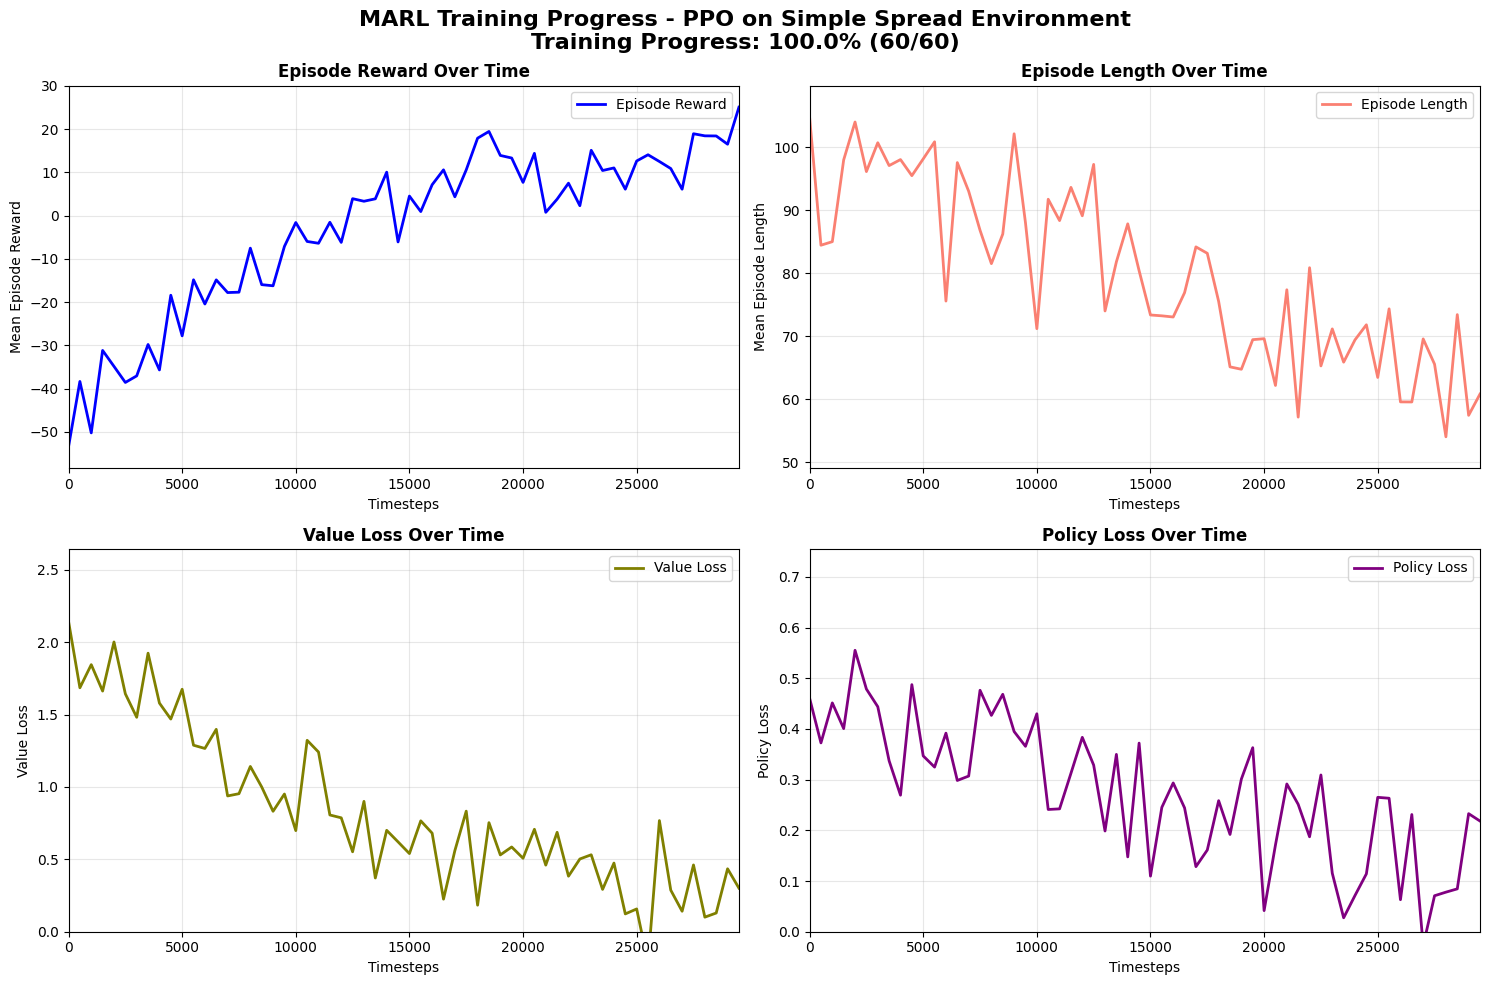

In [18]:
# visualize rewards, episode length, value loss and policu loss over time
gif_file = create_training_history_gif()

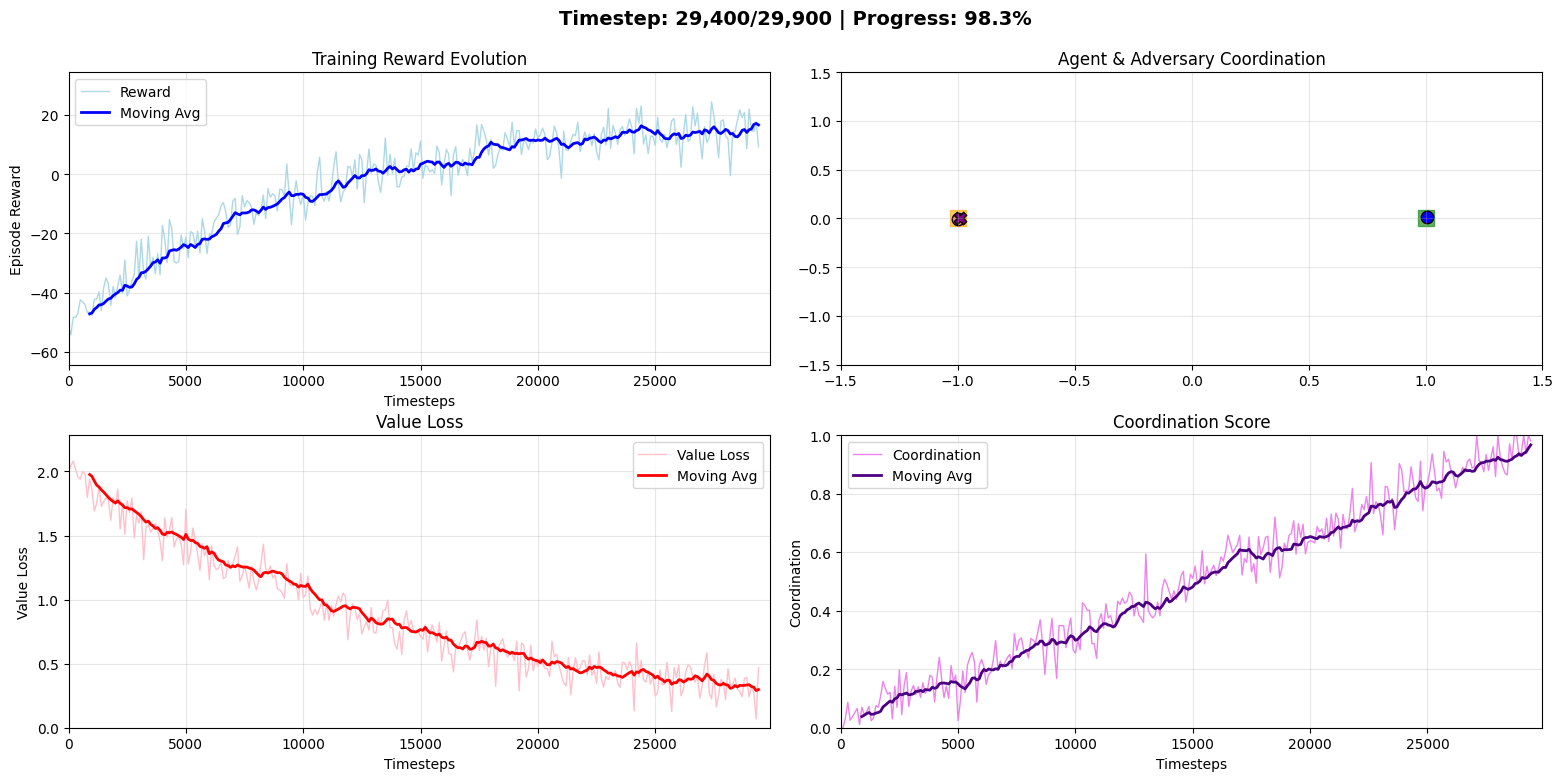

'figures\\training_dashboard_adversary.gif'

In [12]:
# visualize the evolution of rewards with moving avg, coordination score and movement of agents
create_training_dashboard_adversary()

## Test trained agents

In [ ]:
# Load the trained model
model = PPO.load("ppo_marl_simple_spread")

# Create a clean environment for testing (with rendering enabled)
test_env = simple_spread_v3.env(
    N=num_agents,
    local_ratio=0.5,
    max_cycles=100,
    continuous_actions=False,
    render_mode="human",
)
test_env = ss.black_death_v3(test_env)
test_env = ss.flatten_v0(test_env)
test_env = aec_to_parallel(test_env)
test_env = ss.pettingzoo_env_to_vec_env_v1(test_env)
test_env = ss.concat_vec_envs_v1(
    test_env, 1, num_cpus=1, base_class="stable_baselines3"
)

print("Testing trained agents...")
obs = test_env.reset()
for i in range(100):  # Run for 50 steps
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = test_env.step(action)
    test_env.render()  # This will show the visualization
    time.sleep(0.1)  # Slow down for better visualization

    if dones.all():
        obs = test_env.reset()
        print(f"Episode finished at step {i}")

test_env.close()

Testing trained agents...
